This notebook is an example of use of 3D FFTs on the Johns Hopkins turbulence databases to calculate vorticity and dissipation rate (strain rate) level curves using spectral derivatives. It is very important that the commented line below, refering to 'ipcluster' to be run in a separate notebook, to start an ipcluster mpi enviroment. Also, the cell magic '%%px' must be present in all cells using mpi.

In [1]:
#!ipcluster start -n 8 --engines=MPI --profile='mpi' # for parallel run: start the engines using terminal
from ipyparallel import Client
rc = Client(profile='mpi')


Before anything else, it is necessary to import all libraries, which includes, numpy, pyFFTW for Fourier transform, mpi4py for paralellism, pyJHTDB for download, and the remainder Kun's libraries, FFT3D, IFFT3D and energy spectrum.

In [2]:
%%px
# Import the libraries

import pyfftw as ft 
import numpy as np
from mpi4py import MPI
import math
import sys
import os
import pyJHTDB
from pyJHTDB.dbinfo import isotropic1024coarse
from pyJHTDB import libJHTDB

from FFT3Dfield import FFT3Dfield
from IFFT3Dfield import IFFT3Dfield
from EnergySpectrum import EnergySpectrum

Then we set the parameters related to the dataset we are interested in, which include $N_x$,$N_y$ and $N_z$ for the domain grid, $L_x$,$L_y$ and $L_z$ for the size.

In [3]:
%%px

Nx = isotropic1024coarse['nx']
Ny = isotropic1024coarse['ny']
Nz = isotropic1024coarse['nz']
Lx = isotropic1024coarse['lx']
Ly = isotropic1024coarse['ly']
Lz = isotropic1024coarse['lz']

It is necessary to get the data from the MPI communicator, in this case MPI.COMM_WORLD, and inquire each process rank (my_id) and the number of processes.

In [4]:
%%px

comm = MPI.COMM_WORLD
my_id = comm.Get_rank()
nproc = comm.Get_size()
if(my_id==0):
    print("n_proc = "+str(nproc))
    print("my_id = "+str(my_id))

[stdout:2] 
n_proc = 4
my_id = 0


The input for Kun's libraries are the local domains, not the complete domains, among processes, do nx is to be split among the number os processes. Ny and Nz are kept, and for the FFT, it is stored only half of the points, via nz_half. 

In [5]:
%%px 
# Computational Domain

nx=Nx//nproc
ny=Ny
nz=Nz#//nproc
nz_half=nz//2
nek=int(math.sqrt(2.0)/3*Nx)

The maximum chunk size the database can download on a single function call is $1024 \times 1024 \times 32$, so we must divide the domain in 32 points wide slabs. The number of slabs is, thefore $n_x/32 = (N_x/nprocs)/32$

In [6]:
%%px 

time = 0.0

chkSz = 32
slabs = nx//chkSz

##########################################

if(my_id==0):
    print("Preparing the appropiate widths")
    
##########################################

[stdout:2] Preparing the appropiate widths


Here is the part that queries the database. Each process calls the database separately using getRawVelocity, similarly to the cutout service. The input must be the queried time, the list of the leftmost corner of the cube, the width of the cube, the dataset and the field required. Here we query the 'isotropic1024coarse' dabase for the velocity field.

In [7]:
%%px
# Populate velocity field from the Database
comm.Barrier(); t1=MPI.Wtime()

if(my_id==0):
    print("Starting the loading process")

##########################################

lJHTDB = libJHTDB()
lJHTDB.initialize()
ud = []
for k in range(slabs):
    if(my_id==0):
        print(k)
    start = np.array([my_id*nx+k*chkSz, 0, 0],dtype=np.int)
    width = np.array([chkSz,ny,nz],dtype=np.int)
    #start = np.array([ 0, 0, my_id*nx+k*chkSz],dtype=np.int)
    ud.append(lJHTDB.getRawData(time,start,width, 
                               data_set = 'isotropic1024coarse',
                               getFunction = 'Velocity') )

lJHTDB.finalize()

if(my_id==0):
    print("Finished loading")

comm.Barrier(); t2=MPI.Wtime()
if(my_id==0):
    sys.stdout.write('Load velocity field cost: {0:.2f} seconds\n'.format(t2-t1))

[stdout:2] 
Starting the loading process
0
1
2
3
4
5
6
7
Finished loading
Load velocity field cost: 271.26 seconds


Afterward, the downloaded data must be concatenated in a single array for each process.

In [8]:
%%px

comm.Barrier(); t1=MPI.Wtime()
u = np.concatenate(ud,axis=2)
#u = np.concatenate(ud,axis=0)

if(my_id==0):
    print('u.shape: seconds\n'+str(u.shape))

comm.Barrier(); t2=MPI.Wtime()
if(my_id==0):
    sys.stdout.write('Concatenate loaded vectors: {0:.2f} seconds\n'.format(t2-t1))

[stdout:2] 
u.shape: seconds
(1024, 1024, 256, 3)
Concatenate loaded vectors: 14.03 seconds


And then reshaped to properly be manipulated by the fourier transform. The way the downloads stores the data is slightly different from what the library suposed.

In [9]:
%%px

comm.Barrier(); t1=MPI.Wtime()

rsh = np.transpose(u,(2,1,0,3)) #u.reshape((nx,ny,nz, 3))

comm.Barrier(); t2=MPI.Wtime()
if(my_id==0):
    sys.stdout.write('Transpose: {0:.2f} seconds\n'.format(t2-t1))

[stdout:2] Transpose: 0.00 seconds


Next, it is necessary to split the original 3 component vector field into 3 single component fields, because that is 
how the FFT library requests it's inputs. Also, it also requires that the input vectors a aligned. 

In [10]:
%%px

comm.Barrier(); t1=MPI.Wtime()
##########################################
vx = ft.zeros_aligned((nx,ny,nz), dtype='float32')
vy = ft.zeros_aligned((nx,ny,nz), dtype='float32')
vz = ft.zeros_aligned((nx,ny,nz), dtype='float32')

vx[:,:,:] = rsh[:,:,:,0]
vy[:,:,:] = rsh[:,:,:,1]
vz[:,:,:] = rsh[:,:,:,2]

if(my_id==0):
    print("vx shape = "+str(vx.shape))

if(my_id==0):
    print("Spliting")
    
comm.Barrier(); t2=MPI.Wtime()
if(my_id==0):
    sys.stdout.write('Split the loaded vector on float32 aligned vectors: {0:.2f} seconds\n'.format(t2-t1))

##########################################

[stdout:2] 
vx shape = (256, 1024, 1024)
Spliting
Split the loaded vector on float32 aligned vectors: 125.11 seconds


Than, it is necessary to calculate the associated wave-numbers.

In [11]:
%%px
comm.Barrier(); t1=MPI.Wtime()
# Get wavenumber:
myEnergySpc=EnergySpectrum()
kx,ky,kz=myEnergySpc.FindWavenumber(nx,ny,nz,my_id)
k2=np.zeros((nx,ny,nz_half+1), dtype='float32')
np.copyto(k2,kx*kx+ky*ky+kz*kz)
k2[0,0,0]=1e-6

comm.Barrier(); t2=MPI.Wtime()
if(my_id==0):
    sys.stdout.write('Calculate all wavenumbers: {0:.2f} seconds\n'.format(t2-t1))

[stdout:2] Calculate all wavenumbers: 24.45 seconds


In [12]:
%%px
comm.Barrier(); t1=MPI.Wtime()
# Get velocity field in Fourier space:
myFFT3Dfield=FFT3Dfield()
cvx=myFFT3Dfield.GetFFT3Dfield(vx,nx,ny,nz,nproc,my_id)
cvy=myFFT3Dfield.GetFFT3Dfield(vy,nx,ny,nz,nproc,my_id)
cvz=myFFT3Dfield.GetFFT3Dfield(vz,nx,ny,nz,nproc,my_id)

comm.Barrier(); t2=MPI.Wtime()
if(my_id==0):
    sys.stdout.write('Calculate 3D spatial FFT: {0:.2f} seconds\n'.format(t2-t1))

[stdout:2] Calculate 3D spatial FFT: 146.86 seconds


In [13]:
%%px
comm.Barrier(); t1=MPI.Wtime()

cwx=np.complex64(0.0+1.0j)*(ky*cvz-kz*cvy)
cwy=np.complex64(0.0+1.0j)*(kx*cvz-kz*cvx)
cwz=np.complex64(0.0+1.0j)*(kx*cvy-ky*cvx)

comm.Barrier(); t2=MPI.Wtime()
if(my_id==0):
    sys.stdout.write('Calculate vorticity in k space: {0:.2f} seconds\n'.format(t2-t1))

[stdout:2] Calculate vorticity in k space: 35.89 seconds


In [14]:
%%px
if(my_id==0):
    print("cwx.shape = "+str(cwx.shape))
    print("cwx.shape = "+str(cwy.shape))
    print("cwx.shape = "+str(cwz.shape))

[stdout:2] 
cwx.shape = (256, 1024, 513)
cwx.shape = (256, 1024, 513)
cwx.shape = (256, 1024, 513)


In [15]:
%%px
comm.Barrier(); t1=MPI.Wtime()
## Get energy spectrum in Fourier space

ek_unfltrd=myEnergySpc.GetSpectrumFromComplexField(cwx,cwy,cwz,k2,nx,ny,nz,nek,nproc,my_id) 

comm.Barrier(); t2=MPI.Wtime()
if(my_id==0):
    sys.stdout.write('Calculate 3d spectra from the spatial vectors: {0:.2f} seconds\n'.format(t2-t1))

[stdout:2] Calculate 3d spectra from the spatial vectors: 42.47 seconds


[output:2]

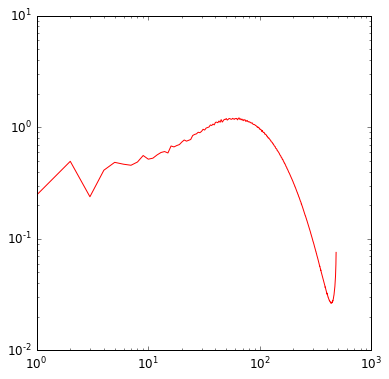

In [16]:
%%px
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
if my_id==0:
    SIZE = 12
    plt.rc('font', size=SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE+4)  # fontsize of the x any y labels
    plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE+3)  # legend fontsize
    #plt.rc('figure', titlesize=SIZE)  # # size of the figure title
    ks=np.linspace(1,nek,nek)
    plt.figure(figsize=(6,6))

    plt.loglog(ks,ek_unfltrd,'r',label='Unfiltered')

In [18]:
%%px
comm.Barrier(); t1=MPI.Wtime()
# Get velocity field in Fourier space:

miFFT3Dfield=IFFT3Dfield()
wx=miFFT3Dfield.GetIFFT3Dfield(cwx,nx,ny,nz,nproc,my_id)
wy=miFFT3Dfield.GetIFFT3Dfield(cwy,nx,ny,nz,nproc,my_id)
wz=miFFT3Dfield.GetIFFT3Dfield(cwz,nx,ny,nz,nproc,my_id)

comm.Barrier(); t2=MPI.Wtime()
if(my_id==0):
    sys.stdout.write('Calculate 3D spatial inverse FFT: {0:.2f} seconds\n'.format(t2-t1))

[stdout:0] Calculate 3D spatial inverse FFT: 90.51 seconds


In [19]:
%%px
sigma2_w = np.average(wx**2+wy**2+wz**2)

In [20]:
%%px
print("sigma2 - "+str(my_id)+": "+str(sigma2_w))

[stdout:0] sigma2 - 0: 259.287
[stdout:1] sigma2 - 4: 234.726
[stdout:2] sigma2 - 1: 237.589
[stdout:3] sigma2 - 7: 254.313
[stdout:4] sigma2 - 6: 257.141
[stdout:5] sigma2 - 5: 216.478
[stdout:6] sigma2 - 2: 206.276
[stdout:7] sigma2 - 3: 199.088


In [21]:
%%px

sw2 = []
if(my_id==0):
    sw2.append(sigma2_w)
    for j in range(1,nproc):
        sigma2_w = comm.recv(source=j,tag=11)
        sw2.append(sigma2_w)
else:
    comm.send(sigma2_w,dest=0,tag=11)

In [22]:
%%px
wrms = 0
if(my_id==0):
    print(sw2)
    sigma2 = np.average(np.array(sw2))
    print(sigma2)
    wrms = sigma2**0.5
    print("RMS vorticity = \omega_{rms} = "+str(wrms)+" s^{-1}")
    for j in range(1,nproc):
        comm.send(wrms,dest=j,tag=11)
else:
    wrms = comm.recv(source=0,tag=11)

[stdout:0] 
[259.28671, 237.5885, 206.27568, 199.0881, 234.72603, 216.47806, 257.14105, 254.31326]
233.112
RMS vorticity = \omega_{rms} = 15.2680117441 s^{-1}


In [23]:
%%px 
wmod = (wx**2+wy**2+wz**2)**0.5

In [35]:
%%px
print("Process - "+str(my_id))
for i in range(20,1,-1):
    wtrsh = wmod[wmod>i*wrms]
    print("# of points > "+str(i)+" sigma: "+str(wtrsh.shape[0]))

[stdout:0] 
Process - 0
# of points > 20 sigma: 2
# of points > 19 sigma: 5
# of points > 18 sigma: 65
# of points > 17 sigma: 150
# of points > 16 sigma: 225
# of points > 15 sigma: 313
# of points > 14 sigma: 432
# of points > 13 sigma: 614
# of points > 12 sigma: 945
# of points > 11 sigma: 1626
# of points > 10 sigma: 3213
# of points > 9 sigma: 6882
# of points > 8 sigma: 15101
# of points > 7 sigma: 34327
# of points > 6 sigma: 82219
# of points > 5 sigma: 209654
# of points > 4 sigma: 594035
# of points > 3 sigma: 1929587
# of points > 2 sigma: 7496308
[stdout:1] 
Process - 4
# of points > 20 sigma: 0
# of points > 19 sigma: 0
# of points > 18 sigma: 0
# of points > 17 sigma: 1
# of points > 16 sigma: 28
# of points > 15 sigma: 113
# of points > 14 sigma: 219
# of points > 13 sigma: 377
# of points > 12 sigma: 806
# of points > 11 sigma: 1675
# of points > 10 sigma: 2848
# of points > 9 sigma: 5033
# of points > 8 sigma: 10153
# of points > 7 sigma: 22715
# of points > 6 sigma: 

In [25]:
%%px
comm.Barrier(); t1=MPI.Wtime()

cSxx=np.complex64(0.0+0.5j)*(kx*cvx+kx*cvx)
cSyy=np.complex64(0.0+0.5j)*(ky*cvy+ky*cvy)
cSzz=np.complex64(0.0+0.5j)*(kz*cvz+kz*cvz)
cSyz=np.complex64(0.0+0.5j)*(ky*cvz+kz*cvy)
cSxz=np.complex64(0.0+0.5j)*(kx*cvz+kz*cvx)
cSxy=np.complex64(0.0+0.5j)*(kx*cvy+ky*cvx)

comm.Barrier(); t2=MPI.Wtime()
if(my_id==0):
    sys.stdout.write('Calculate vorticity in k space: {0:.2f} seconds\n'.format(t2-t1))

[stdout:0] Calculate vorticity in k space: 34.56 seconds


In [26]:
%%px
comm.Barrier(); t1=MPI.Wtime()
# Get velocity field in Fourier space:

miFFT3Dfield=IFFT3Dfield()
Sxx=miFFT3Dfield.GetIFFT3Dfield(cSxx,nx,ny,nz,nproc,my_id)
Syy=miFFT3Dfield.GetIFFT3Dfield(cSyy,nx,ny,nz,nproc,my_id)
Szz=miFFT3Dfield.GetIFFT3Dfield(cSzz,nx,ny,nz,nproc,my_id)
Syz=miFFT3Dfield.GetIFFT3Dfield(cSyz,nx,ny,nz,nproc,my_id)
Sxz=miFFT3Dfield.GetIFFT3Dfield(cSxz,nx,ny,nz,nproc,my_id)
Sxy=miFFT3Dfield.GetIFFT3Dfield(cSxy,nx,ny,nz,nproc,my_id)

comm.Barrier(); t2=MPI.Wtime()
if(my_id==0):
    sys.stdout.write('Calculate 3D spatial inverse FFT: {0:.2f} seconds\n'.format(t2-t1))

[stdout:0] Calculate 3D spatial inverse FFT: 166.20 seconds


In [28]:
%%px
S2 = Sxx**2+ Syy**2+ Szz**2+ Sxy**2+ Syz**2 +Sxz**2
S2avg = np.average(S2)

In [30]:
%%px
print("S2avg = "+str(S2avg))

[stdout:0] S2avg = 265.793
[stdout:1] S2avg = 248.121
[stdout:2] S2avg = 243.21
[stdout:3] S2avg = 260.263
[stdout:4] S2avg = 267.624
[stdout:5] S2avg = 226.689
[stdout:6] S2avg = 211.309
[stdout:7] S2avg = 208.394


In [31]:
%%px

s2sum = []
if(my_id==0):
    s2sum.append(S2avg)
    for j in range(1,nproc):
        s2part = comm.recv(source=j,tag=11)
        s2sum.append(s2part)
else:
    comm.send(sigma2_w,dest=0,tag=11)

In [32]:
%%px
Srms = 0
if(my_id==0):
    print(s2sum)
    Ssigma2 = np.average(np.array(s2sum))
    print(Ssigma2)
    Srms = Ssigma2**0.5
    print("RMS strain = S_{rms} = "+str(Srms)+" s^{-1}")
    for j in range(1,nproc):
        comm.send(Srms,dest=j,tag=11)
else:
    Srms = comm.recv(source=0,tag=11)

[stdout:0] 
[265.79257, 237.5885, 206.27568, 199.0881, 234.72603, 216.47806, 257.14105, 254.31326]
233.925
RMS strain = S_{rms} = 15.2946204608 s^{-1}


In [33]:
%%px 
Smod = S2**0.5

In [36]:
%%px
print("Process - "+str(my_id))
for i in range(20,1,-1):
    wtrsh = Smod[Smod>i*Srms]
    print("# of points > "+str(i)+" sigma: "+str(wtrsh.shape[0]))

[stdout:0] 
Process - 0
# of points > 20 sigma: 2
# of points > 19 sigma: 6
# of points > 18 sigma: 11
# of points > 17 sigma: 14
# of points > 16 sigma: 25
# of points > 15 sigma: 40
# of points > 14 sigma: 76
# of points > 13 sigma: 166
# of points > 12 sigma: 363
# of points > 11 sigma: 886
# of points > 10 sigma: 2054
# of points > 9 sigma: 4654
# of points > 8 sigma: 10845
# of points > 7 sigma: 25770
# of points > 6 sigma: 63466
# of points > 5 sigma: 167895
# of points > 4 sigma: 493523
# of points > 3 sigma: 1691176
# of points > 2 sigma: 7058028
[stdout:1] 
Process - 4
# of points > 20 sigma: 0
# of points > 19 sigma: 0
# of points > 18 sigma: 0
# of points > 17 sigma: 0
# of points > 16 sigma: 3
# of points > 15 sigma: 20
# of points > 14 sigma: 47
# of points > 13 sigma: 98
# of points > 12 sigma: 217
# of points > 11 sigma: 508
# of points > 10 sigma: 1240
# of points > 9 sigma: 3030
# of points > 8 sigma: 7532
# of points > 7 sigma: 18437
# of points > 6 sigma: 47286
# of 